# Benchmark model

Credit: https://www.kaggle.com/yekenot/2dcnn-textclassifier

Benchmark model but trainable=False on embeddable.
The validation F1-score is 0.6577 at a threshold of 0.31. This is a drop over the benchmark.

# Constants

In [1]:
MODEL_VERSION = 'benchmarkV2'
MAX_SEQUENCE_LENGTH = 70
EMBEDDING_DIM = 300
MAX_WORDS = 40000

In [2]:
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

In [4]:
X_train = train["question_text"].fillna("fillna").values
y_train = train["target"].values
X_test = test["question_text"].fillna("fillna").values


tokenizer = text.Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
x_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [5]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [6]:
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

In [7]:
filter_sizes = [1,2,3,5]
num_filters = 42
    
def get_model():    
    inp = Input(shape=(MAX_SEQUENCE_LENGTH, ))
    x = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inp)
#    x = SpatialDropout1D(0.4)(x)
    x = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1))(x)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM),
                                 kernel_initializer='he_normal', activation='tanh')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM),
                                 kernel_initializer='he_normal', activation='tanh')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), 
                                 kernel_initializer='he_normal', activation='tanh')(x)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], EMBEDDING_DIM),
                                 kernel_initializer='he_normal', activation='tanh')(x)
    
    maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1))(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1))(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1))(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[3] + 1, 1))(conv_3)
        
    z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
    z = Flatten()(z)
    z = Dropout(0.1)(z)
        
    outp = Dense(1, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', f1, recall, precision])

    return model

model = get_model()

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 300)      12000000    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 70, 300, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 70, 1, 42)    12642       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
batch_size = 256
epochs = 2

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.8,
                                              random_state=233)

hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_val, y_val), verbose=1)

Train on 1044897 samples, validate on 261225 samples
Epoch 1/2
1044897/1044897 [==============================] - 38s 36us/step - loss: 0.1171 - acc: 0.9539 - f1: 0.5418 - recall: 0.4688 - precision: 0.6817 - val_loss: 0.1075 - val_acc: 0.9576 - val_f1: 0.6055 - val_recall: 0.5452 - val_precision: 0.7016
Epoch 2/2
1044897/1044897 [==============================] - 34s 33us/step - loss: 0.1063 - acc: 0.9579 - f1: 0.6004 - recall: 0.5344 - precision: 0.7158 - val_loss: 0.1055 - val_acc: 0.9580 - val_f1: 0.6088 - val_recall: 0.5484 - val_precision: 0.7080


# Predict validation labels

In [9]:
%%time

pred_val = model.predict([X_val], batch_size=1024, verbose=1)

261225/261225 [==============================] - 2s 8us/step
CPU times: user 1.12 s, sys: 128 ms, total: 1.25 s
Wall time: 2.2 s


# Find optimal threshold

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score

def optimalThreshold(y_true,y_pred):
    idx = 0
    cur_f1 = 0
    cur_prec = 0
    cur_recall = 0
    max_f1 = 0
    thres = 0
    for idx in np.arange(0.1, 0.501, 0.01):
        cur_f1 = f1_score(y_true, np.array(y_pred)> idx)
        cur_recall = recall_score(y_true, np.array(y_pred)> idx)
        cur_prec = precision_score(y_true, np.array(y_pred)> idx)
        print('Current threshold is {:.4f} with F1 score: {:.4f}, Recall score: {:.4f}, Precision score: {:.4f}'
              .format(idx, cur_f1, cur_recall, cur_prec)
             )
        if cur_f1 > max_f1:
            max_f1 = cur_f1
            thres = idx
    print('optimal threshold is {:.4f} with F1 score: {:.4f}'.format(thres, max_f1))
    return thres
threshold = optimalThreshold(y_val,pred_val)

Current threshold is 0.1000 with F1 score: 0.5738, Recall score: 0.8808, Precision score: 0.4255
Current threshold is 0.1100 with F1 score: 0.5845, Recall score: 0.8721, Precision score: 0.4395
Current threshold is 0.1200 with F1 score: 0.5942, Recall score: 0.8624, Precision score: 0.4533
Current threshold is 0.1300 with F1 score: 0.6026, Recall score: 0.8533, Precision score: 0.4657
Current threshold is 0.1400 with F1 score: 0.6105, Recall score: 0.8453, Precision score: 0.4778
Current threshold is 0.1500 with F1 score: 0.6173, Recall score: 0.8369, Precision score: 0.4890
Current threshold is 0.1600 with F1 score: 0.6240, Recall score: 0.8294, Precision score: 0.5001
Current threshold is 0.1700 with F1 score: 0.6291, Recall score: 0.8207, Precision score: 0.5101
Current threshold is 0.1800 with F1 score: 0.6339, Recall score: 0.8129, Precision score: 0.5196
Current threshold is 0.1900 with F1 score: 0.6373, Recall score: 0.8048, Precision score: 0.5275
Current threshold is 0.2000 wi

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, np.array(pred_val > threshold).astype(int), target_names=['sincere', 'insincere']))


              precision    recall  f1-score   support

     sincere       0.98      0.97      0.98    245044
   insincere       0.61      0.71      0.66     16181

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.80      0.84      0.82    261225
weighted avg       0.96      0.95      0.96    261225



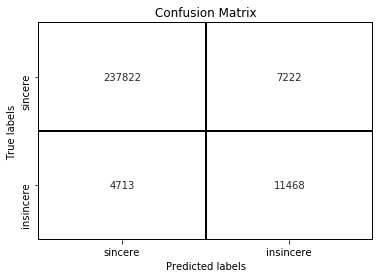

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = confusion_matrix(y_val, np.array(pred_val > threshold).astype(int))
ax = plt.subplot()
hm = sns.heatmap(cm, annot=True, ax = ax, fmt='g', 
                 cmap=ListedColormap(['white']), linecolor='black', 
                 linewidth=1, cbar=False,
                 xticklabels = 1, yticklabels = 1 )


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['sincere', 'insincere'])
ax.yaxis.set_ticklabels(['sincere', 'insincere'])
plt.show()

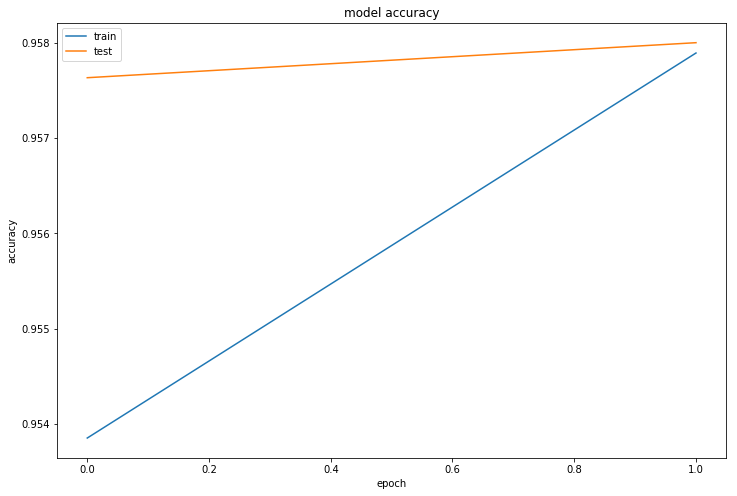

In [13]:
plt.figure(figsize=(12,8))
plt.title('model accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

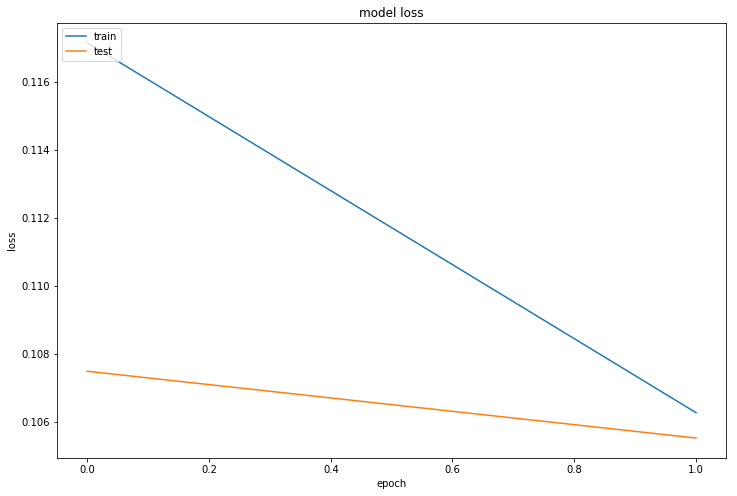

In [14]:
plt.figure(figsize=(12,8))
plt.title('model loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

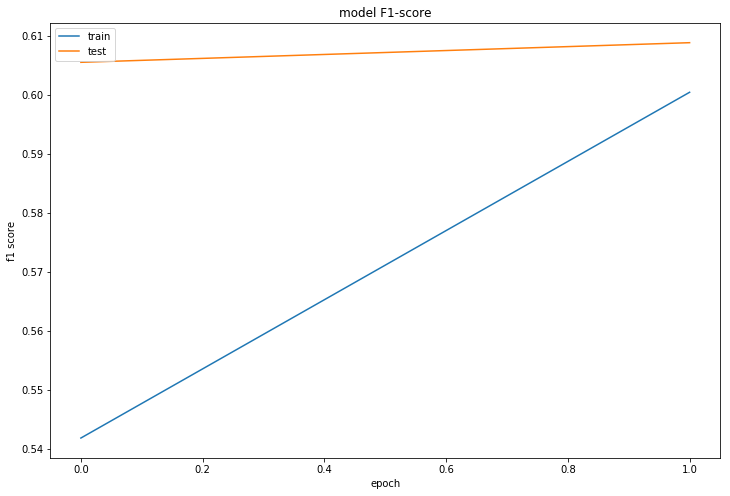

In [15]:
plt.figure(figsize=(12,8))
plt.title('model F1-score')
plt.plot(hist.history['f1'])
plt.plot(hist.history['val_f1'])
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# serialize weights

In [16]:
model.save_weights(MODEL_VERSION + '.weights.h5')
print("Saved model weights to disk")

Saved model weights to disk


# Predict test labels

In [17]:
%%time

pred_test = model.predict([x_test], batch_size=1024, verbose=1)

56370/56370 [==============================] - 0s 8us/step
CPU times: user 208 ms, sys: 24 ms, total: 232 ms
Wall time: 442 ms


# Analyze predictions

In [18]:
prediction_df = pd.DataFrame({"qid":test["qid"].values})
prediction_df['prediction'] = (pred_test > threshold).astype(int)

In [19]:
type(hist)

keras.callbacks.History

In [20]:
import pickle


pickle_out = open(MODEL_VERSION + '.hist.pkl',"wb")
pickle.dump(hist, pickle_out)
pickle_out.close()